In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import organs.system as system
from organs.index import Index
import organs.index as index

In [3]:
p = system.init()

n = len(Index)
y0 = np.zeros(n)

def y0_init(y0: np.ndarray):
    y0[Index.plasma_glucose] = 5.5 #mmol/L
    y0[Index.plasma_insulin] = 1.2 #g/L
    y0[Index.plasma_fattyacid] = 0.4 #mmol/L
    y0[Index.plasma_aminoacid] = 0.2 #mmol/L
    y0[Index.vsc_TAG] = 1 * 1000 /p.V.vsc  # g/L
    y0[Index.subq_TAG] = 1 * 1000 / p.V.subq # g/L

    # volume of skeletal muscle is ~25.0L
    y0[Index.muscle_NAD] = 1.6*(60*.4)/25 #mmol/L 
    y0[Index.muscle_NADH] = 0.15*(60*.4)/25 #mmol/L

    #no certain data for FAD and FADH2, but assume its around 1/3 of NAD
    y0[Index.muscle_FAD] = 1.6*(60*.4)/25/3 # NOTE: NEED UNITS
    y0[Index.muscle_FADH2] = 0.15*(60*.4)/25/3 # NOTE: NEED UNITS

    y0[Index.gut_glucose] = 50 # NOTE: NEED UNITS
    y0[Index.gut_fructose] = 30 # NOTE: NEED UNITS
    y0[Index.plasma_fructose] = 3 # NOTE: NEED UNITS
    y0[Index.micellar_fattyacid] = 100 # NOTE: NEED UNITS
    return

y0_init(y0)
t_span = (0, 300)
t_eval = np.linspace(*t_span, 300)


solution = solve_ivp(fun=lambda t, y: system.system(t, y, p),
                     t_span=t_span,
                     y0=y0,
                     t_eval=t_eval,
                     method='LSODA')

timespan = solution.t

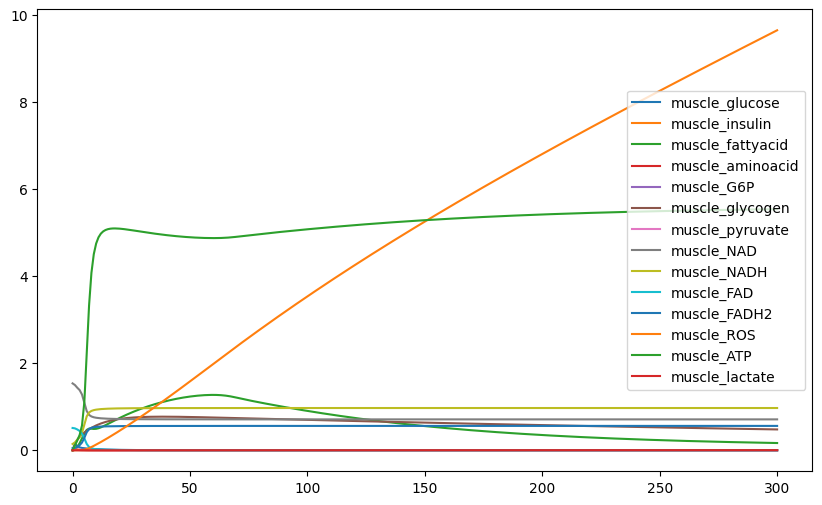

In [6]:
muscle_indices = index.get_muscle_indices()
muscle_names = index.get_muscle_names()


plt.figure(figsize=(10, 6))
for idx, name in zip(muscle_indices, muscle_names):
    if name == "muscle_ACoA": continue
    plt.plot(timespan, solution.y[idx], label=name)
plt.legend(loc="right", bbox_to_anchor=(1, 0.5))
plt.show()

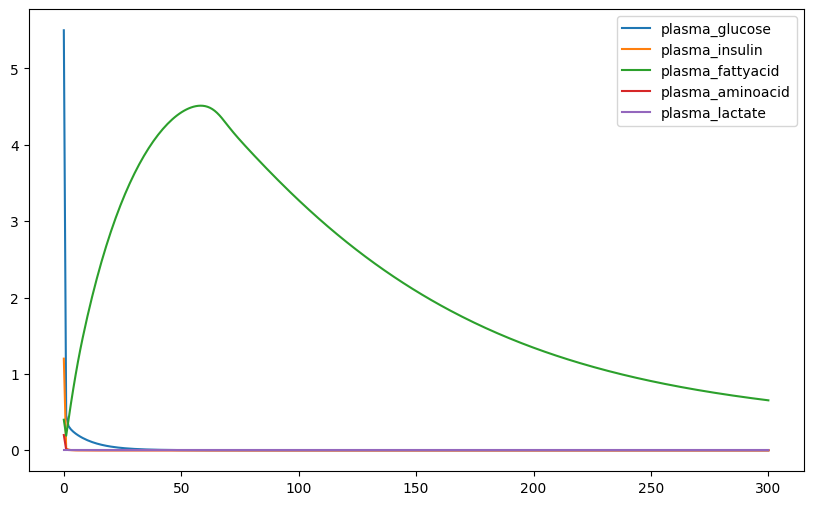

In [ ]:
plasma_indices = index.get_plasma_indices()
plasma_names = index.get_plasma_names()

plt.figure(figsize=(10, 6))
for idx, name in zip(plasma_indices, plasma_names):
    plt.plot(timespan, solution.y[idx], label=name)
plt.legend()
plt.show()

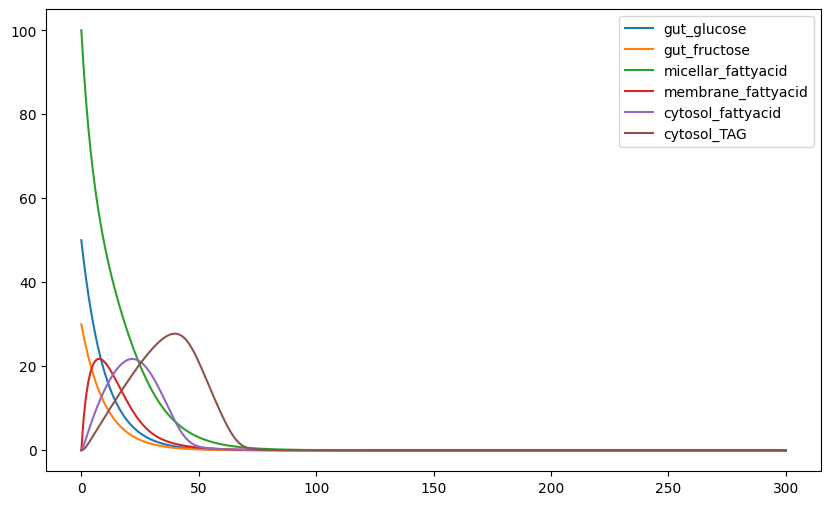

In [ ]:
gut_indices = index.get_gut_indices()
gut_names = index.get_gut_names()

plt.figure(figsize=(10, 6))
for idx, name in zip(gut_indices, gut_names):
    plt.plot(timespan, solution.y[idx], label=name)
plt.legend()
plt.show()

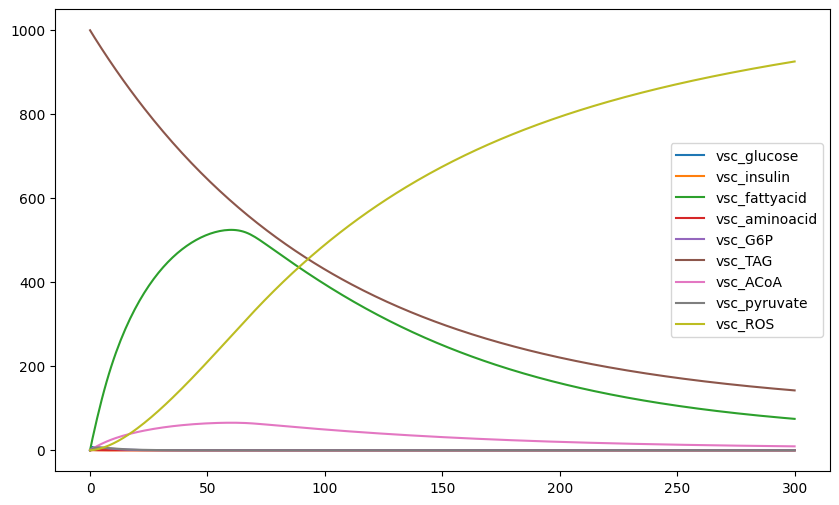

In [ ]:
vsc_indices = index.get_vsc_indices()
vsc_names = index.get_vsc_names()

plt.figure(figsize=(10, 6))
for idx, name in zip(vsc_indices, vsc_names):
    plt.plot(timespan, solution.y[idx], label=name)
plt.legend()
plt.show()

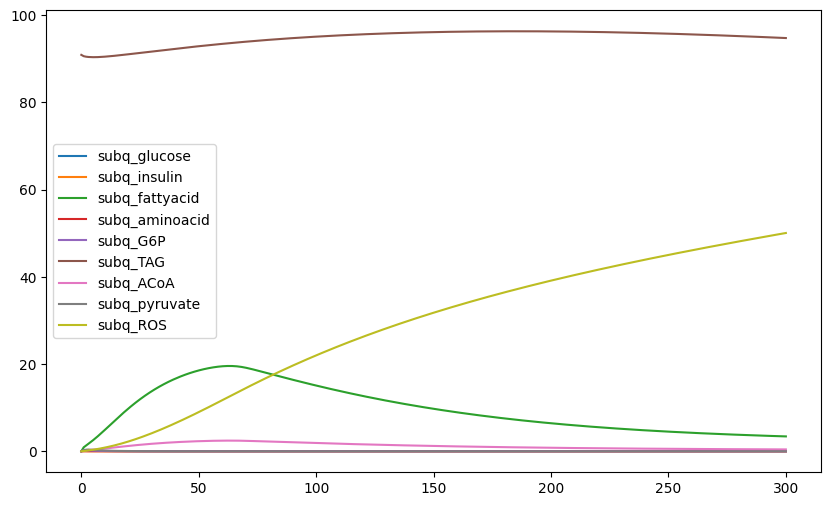

In [ ]:
subq_indices = index.get_subq_indices()
subq_names = index.get_subq_names()

plt.figure(figsize=(10, 6))
for idx, name in zip(subq_indices, subq_names):
    plt.plot(timespan, solution.y[idx], label=name)
plt.legend()
plt.show()